In [19]:
import numpy as np
import tensorflow as tf
from keras.models import load_model

In [20]:
input_step=10 #to change after to 25,50
output_step=10

In [21]:
X1=np.load("X1_"+str(input_step)+".npy")
X2=np.load("X2_"+str(input_step)+".npy")

In [22]:
X1.shape

(56936, 10, 6, 500)

In [23]:
X2.shape

(55002, 10, 6, 500)

In [24]:
X1=np.float32(X1)
X2=np.float32(X2)


In [25]:
from keras.layers import Input, Dense, Reshape, Flatten,Dropout
from keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


input_shape = (input_step,6,500)
hidden_size1 = 256
hidden_size2 = 128
hidden_size3 = 100
code_size = 64

input_layer = Input(shape=(input_shape))
print(input_layer)
hidden_layer_0=Flatten()(input_layer)
hidden_layer_1 = Dense(hidden_size1, activation='relu')(hidden_layer_0)
hidden_layer_2 = Dense(hidden_size2, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(hidden_size3, activation='relu')(hidden_layer_2)
bottleneck_layer = Dense(code_size*input_step, activation='sigmoid')(hidden_layer_3)

# Define the decoder network
hidden_layer_5 = Dense(hidden_size1, activation='relu')(bottleneck_layer)
hidden_layer_6 = Dense(hidden_size2, activation='relu')(hidden_layer_5)
hidden_layer_7 = Dense(hidden_size1, activation='relu')(hidden_layer_6)
hidden_layer_8 = Dense(6*500*input_step, activation='sigmoid')(hidden_layer_7)
output_layer=Reshape((input_step,6,500))(hidden_layer_8)

autoencoder = Model(input_layer, output_layer)
autoencoder.summary()
opt = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss='mae',metrics=['mae', 'mse',tf.keras.metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
autoencoder.fit(X1, X1, epochs=300,batch_size=64,
                validation_data=(X2, X2),callbacks=[early_stopping]
              )

KerasTensor(type_spec=TensorSpec(shape=(None, 10, 6, 500), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 6, 500)]      0         
                                                                 
 flatten_1 (Flatten)         (None, 30000)             0         
                                                                 
 dense_9 (Dense)             (None, 256)               7680256   
                                                                 
 dense_10 (Dense)            (None, 128)               32896     
                                                                 
 dense_11 (Dense)            (None, 100)               12900     
                                                                 
 dense_12 (Dense)            (None, 640

Epoch 27/300
890/890 [==============================] - 50s 56ms/step - loss: 0.0124 - mae: 0.0124 - mse: 0.0021 - root_mean_squared_error: 0.0455 - val_loss: 0.0455 - val_mae: 0.0455 - val_mse: 0.0137 - val_root_mean_squared_error: 0.1170
Epoch 28/300
890/890 [==============================] - 48s 53ms/step - loss: 0.0122 - mae: 0.0122 - mse: 0.0021 - root_mean_squared_error: 0.0454 - val_loss: 0.0455 - val_mae: 0.0455 - val_mse: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 29/300
890/890 [==============================] - 47s 53ms/step - loss: 0.0121 - mae: 0.0121 - mse: 0.0021 - root_mean_squared_error: 0.0453 - val_loss: 0.0445 - val_mae: 0.0445 - val_mse: 0.0134 - val_root_mean_squared_error: 0.1158
Epoch 30/300
890/890 [==============================] - 47s 53ms/step - loss: 0.0119 - mae: 0.0119 - mse: 0.0020 - root_mean_squared_error: 0.0452 - val_loss: 0.0445 - val_mae: 0.0445 - val_mse: 0.0133 - val_root_mean_squared_error: 0.1151
Epoch 31/300
890/890 [==================

In [26]:
encoder = Model(input_layer, bottleneck_layer)
encoder.compile(optimizer='adam', loss='mae')

In [27]:
X11=encoder.predict(X1)
X22=encoder.predict(X2)

1719/1719 [==============================] - 7s 4ms/step


In [28]:
decoder = Model(bottleneck_layer, output_layer)
decoder.compile(optimizer='adam', loss='mae')

In [29]:
Y1=decoder.predict(X11)
Y2=decoder.predict(X22)

1719/1719 [==============================] - 8s 5ms/step


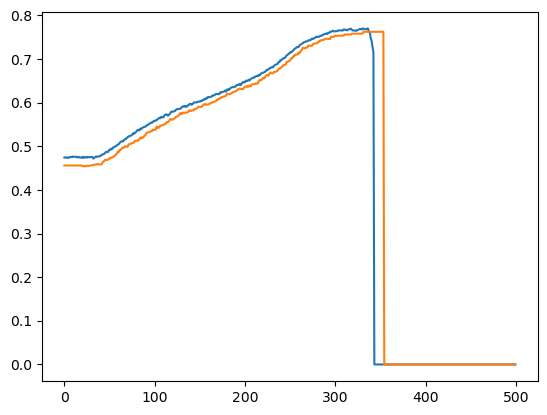

In [30]:
import matplotlib.pyplot as plt
plt.plot(Y2[0][0][5])
plt.plot(X2[0][0][5])

In [31]:
np.save("X11_"+str(input_step),X11)
np.save("X22_"+str(input_step),X22)

In [32]:
encoder.save("encoder-simple_"+str(input_step)+".h5")

# Cnn encoder

In [33]:
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape, UpSampling2D,Dropout
from keras.models import Model

# Define input shape
input_shape = (input_step,6, 500)

# Define encoder architecture
inputs = Input(shape=input_shape)
x = Conv2D(128,3, activation='relu', padding='same' )(inputs)

x = MaxPooling2D((1,2), padding='same')(x)

x = Conv2D(64,3, activation='relu', padding='same')(x)

x = MaxPooling2D((1,2), padding='same')(x)
x = Conv2D(32,3, activation='relu', padding='same')(x)

encoded2 = Reshape((input_step,64))(x)



# Define decoder architecture
x = Reshape((input_step,1,64))(x)
x = Conv2D(64, (1,1), activation='relu', padding='same')(x)
x = UpSampling2D((1,2))(x)
x = Conv2D(100, (1,1), activation='relu', padding='same')(x)
x = UpSampling2D((1,2))(x)
x = Conv2D(128, (1,1), activation='relu', padding='same')(x)
x=Conv2D(252, (1,1), activation='sigmoid')(x)
x=Reshape((input_step,6,168))(x)
x=Dense(500, activation='linear')(x)
x=Reshape((input_step,6,500))(x)

decoded2 = Conv2D(500, 3, activation='sigmoid', padding='same')(x)

# Define autoencoder model
autoencoder2 = Model(inputs=inputs, outputs=decoded2)

# Compile model
autoencoder2.compile(optimizer='adam', loss='mae',metrics=['mae', 'mse',tf.keras.metrics.RootMeanSquaredError()])

# Print model summary
print(autoencoder2.summary())


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 10, 6, 500)]      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 6, 128)        576128    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 3, 128)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 10, 3, 64)         73792     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 10, 2, 64)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 10, 2, 32)         1846

In [34]:
# Train the model
opt = Adam(learning_rate=0.0001)
autoencoder.compile(optimizer=opt, loss='mae',metrics=['mae', 'mse',tf.keras.metrics.RootMeanSquaredError()])
early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min')
autoencoder2.fit(X1, X1, epochs=300,batch_size=64,
                validation_data=(X2, X2),callbacks=[early_stopping]
              )

Epoch 1/300
890/890 [==============================] - 321s 359ms/step - loss: 0.0992 - mae: 0.0992 - mse: 0.0323 - root_mean_squared_error: 0.1798 - val_loss: 0.1280 - val_mae: 0.1280 - val_mse: 0.0464 - val_root_mean_squared_error: 0.2153
Epoch 2/300
890/890 [==============================] - 303s 341ms/step - loss: 0.0912 - mae: 0.0912 - mse: 0.0284 - root_mean_squared_error: 0.1686 - val_loss: 0.1191 - val_mae: 0.1191 - val_mse: 0.0437 - val_root_mean_squared_error: 0.2091
Epoch 3/300
890/890 [==============================] - 293s 329ms/step - loss: 0.0889 - mae: 0.0889 - mse: 0.0277 - root_mean_squared_error: 0.1666 - val_loss: 0.1181 - val_mae: 0.1181 - val_mse: 0.0433 - val_root_mean_squared_error: 0.2082
Epoch 4/300
890/890 [==============================] - 310s 348ms/step - loss: 0.0878 - mae: 0.0878 - mse: 0.0273 - root_mean_squared_error: 0.1653 - val_loss: 0.1171 - val_mae: 0.1171 - val_mse: 0.0422 - val_root_mean_squared_error: 0.2055
Epoch 5/300
890/890 [===============

In [37]:
encoder_2 = Model(inputs, encoded2)
encoder_2.compile(optimizer='adam', loss='mae')

In [38]:
encoder_2.save("encoder_cnn_"+str(input_step)+".h5")